In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import zipfile
import os

import tensorflow as tf
import tensorflow_decision_forests as tfdf

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## Extracting the Data

In [321]:
## Log messages
## How to update old model? warm-start training, model distillation

## Exploratory Data Analysis

In [9]:
def plot_distribution(data, label, rows):
    fig, axs = plt.subplots(nrows = rows)

    sns.histplot(data[label], kde=True, ax=axs[0], stat = 'density', bins = 100)
    sns.boxplot(x=data[label], width = 0.3, ax = axs[1], showfliers = False)

    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    plt.subplots_adjust(hspace = 0)
    fig.suptitle("Distribution of " + label)

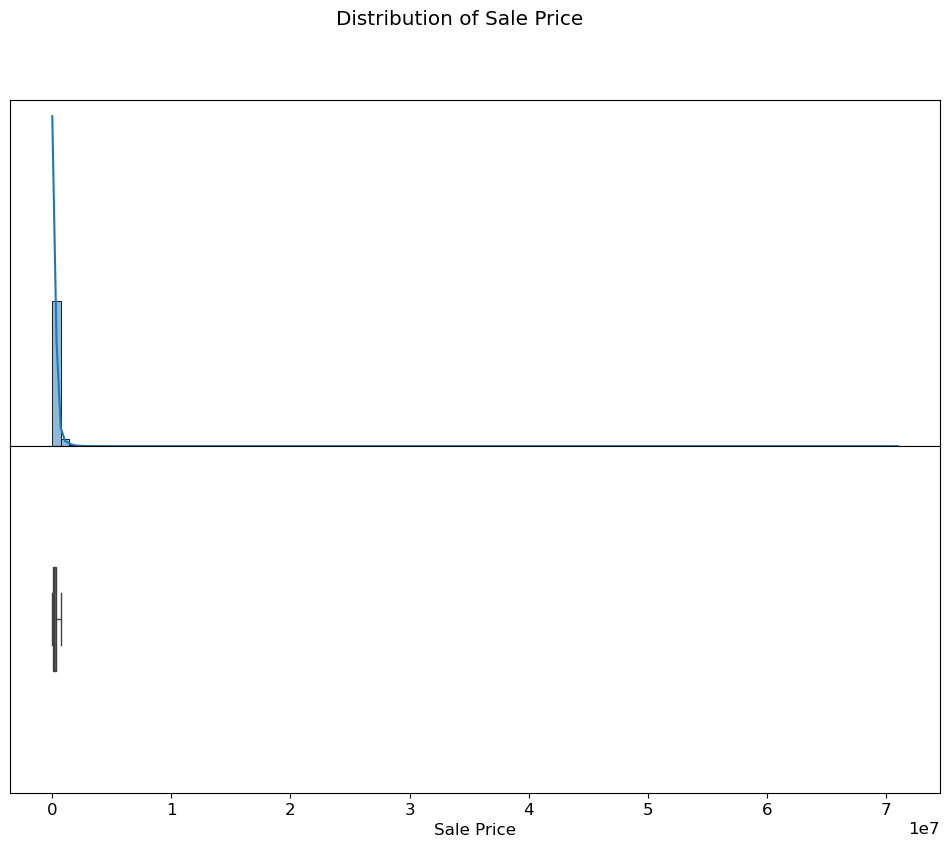

In [10]:
plot_distribution(training_data, label = 'Sale Price', rows = 2)

In [11]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

After seeing the distribution of the data and how large the sale prices can be, I decided to work with log values in order to have a more linear relationship as well as work with smaller values. As we do more preliminary data analysis, we might also want to log transform other columns. Thus we will define create it as a function.

In [13]:
def log_transform(data, col):
    copy = data.copy()
    copy['Log ' + col] = np.log(data[col])
    return copy

In [14]:
training_data = log_transform(training_data, 'Sale Price')

After the log transform, let's take another look at the distribution of the data

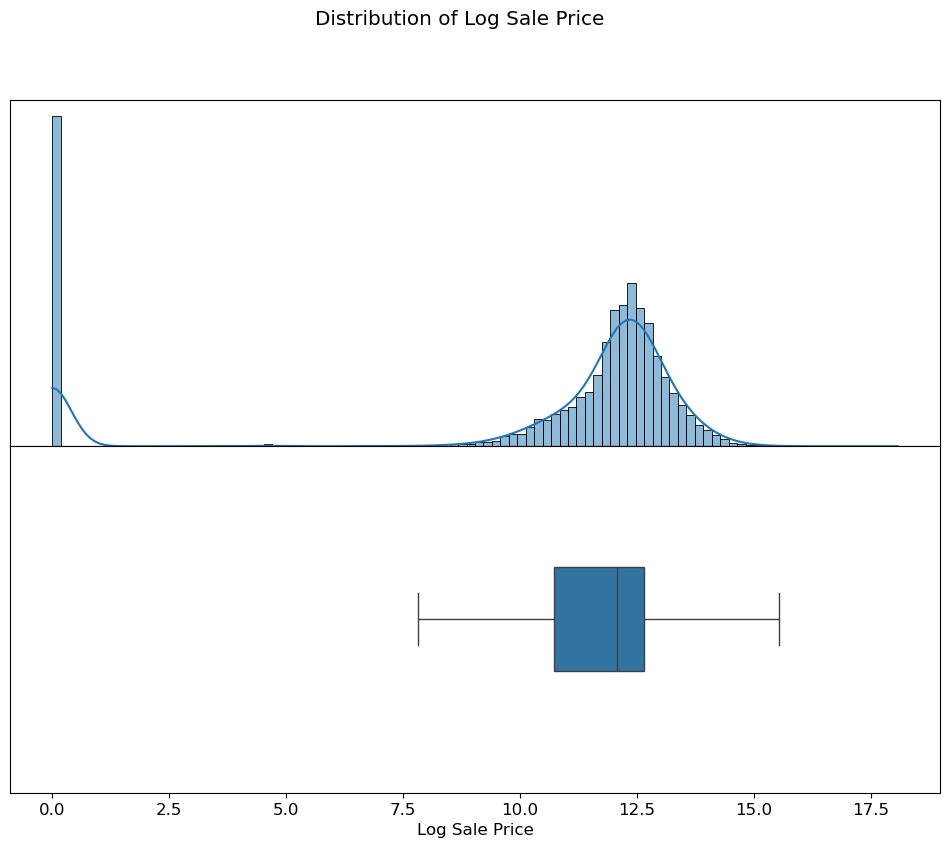

In [16]:
plot_distribution(training_data, label = 'Log Sale Price', rows = 2)

We can now see that there is an outlier that seems to be at 500. So that this doesn't skew our data, we can also define a 'drop outliter' function that removes outliers that may otherwise skew our data. 

In [18]:
def remove_outliers(data, variable, lower = -np.inf, upper = np.inf):
    # Remove outliers from data in column variable that are lower than lower and higher than upper
    data = data[(data[variable] > lower) & (data[variable] <= upper)]
    return data

We now remove the outlier

In [20]:
training_data = remove_outliers(training_data, 'Sale Price', lower = 500)

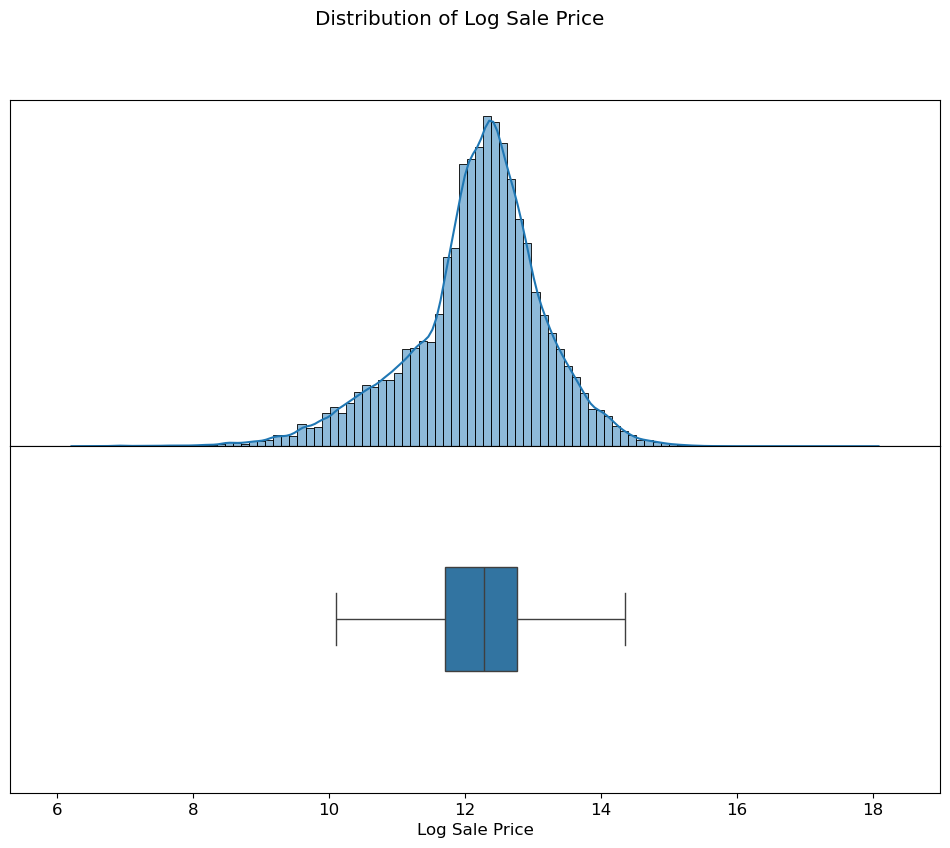

In [21]:
plot_distribution(training_data, label = 'Log Sale Price', rows = 2)

Now the distribution looks roughly normal! This will make building our model easier as errors will be more standardized, leading to better predictions as well.

Now let's take a look at the distribution of some other variables

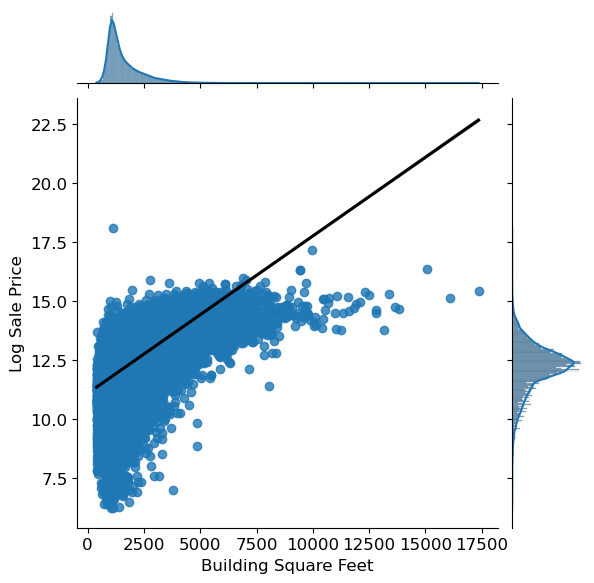

In [23]:
sns.jointplot(data = training_data, x = 'Building Square Feet', y = 'Log Sale Price', kind = 'reg', line_kws = {'color':'black'})

Again we see that the Building Square Feet column is quite skewed. In order to normalize the distribution we should once again log it. Good thing we defined the log_transform function!

In [25]:
training_data= log_transform(training_data, 'Building Square Feet')

Let's see how the distribution looks after the log transformation.

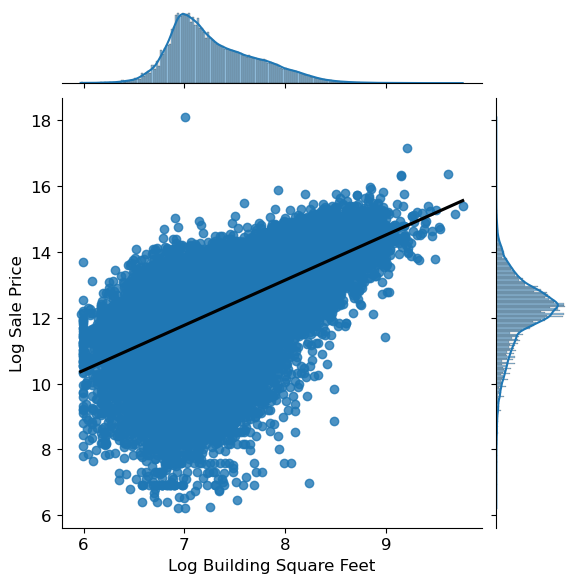

In [27]:
sns.jointplot(data = training_data, x = 'Log Building Square Feet', y = 'Log Sale Price', kind = 'reg', line_kws = {'color':'black'})

So much better! Now both distributions look a lot closer to normal, and there can roughly be a linear relationship observed between the two. 

Moving on to other columns, we see a Description column. Let's see what kind of information we can observe there.

In [30]:
training_data['Description'][1]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

It seems like description has the sell date, address, number of rooms, bedrooms, and bathrooms. Let's take a look at a couple more descriptions to see if they are standardized.

In [32]:
training_data['Description'][8]

'This property, sold on 08/25/2016, is a two-story houeshold located at 3940 N CHRISTIANA AVE.It has a total of 8 rooms, 4 of which are bedrooms, and 2.0 of which are bathrooms.'

In [33]:
training_data['Description'][17]

'This property, sold on 06/29/2016, is a one-story houeshold located at 131 DETROIT ST.It has a total of 7 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.'

In [34]:
training_data['Description'][429]

'This property, sold on 03/25/2014, is a two-story houeshold located at 14203 WOODWARD DR.It has a total of 9 rooms, 5 of which are bedrooms, and 2.5 of which are bathrooms.'

Looking at the codebook we can see that bedroom, rooms, and bathrooms are not included within the dataset explicitly. However, anyone who has any knowledge of housing prices knows that these are important! Since the descriptions look to be standardized, let's create a function for processing the total number of bedrooms, bathrooms, and rooms in general.

In [36]:
def add_bedrooms(data):
    with_rooms = data.copy()
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(r'(\d+) of which are bedrooms,').astype(int).fillna(0)
    return with_rooms

def add_total_rooms(data):
    with_rooms = data.copy()
    with_rooms['Rooms'] = with_rooms['Description'].str.extract(r'It has a total of (\d+) rooms,').astype(int).fillna(0)
    return with_rooms

def add_bathrooms(data):
    with_rooms = data.copy()
    with_rooms['Bathrooms'] = with_rooms['Description'].str.extract(r'(\d+(?:\.\d+)?) of which are bathrooms.').astype(float).fillna(0)
    return with_rooms

Now let's add these variables to the data and look at their distribution!

In [38]:
training_data = add_bathrooms(training_data)
training_data = add_bedrooms(training_data)
training_data = add_total_rooms(training_data)

<Axes: xlabel='Bathrooms', ylabel='Log Sale Price'>

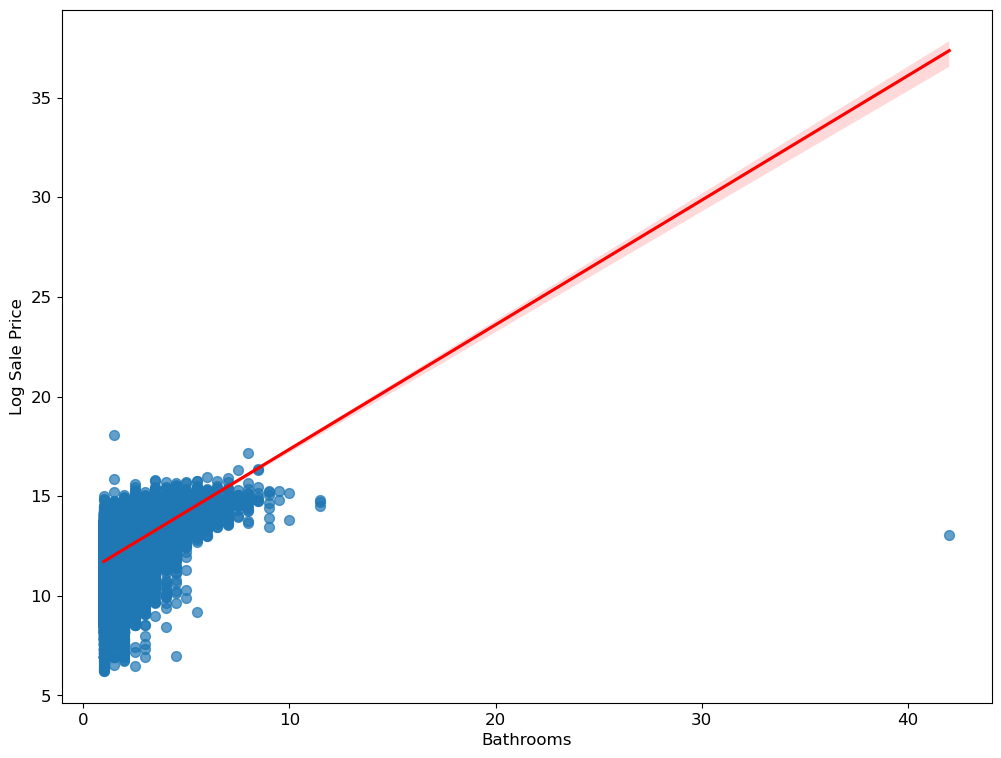

In [39]:
sns.regplot(x='Bathrooms', y='Log Sale Price', data = training_data, 
            scatter_kws = {'s':50, 'alpha':0.7}, 
            line_kws = {'color':'red'})

This data looks a little too clustered for us to be able to glean anything from it. Let's try a different graph.

<Axes: xlabel='Bedrooms', ylabel='Log Sale Price'>

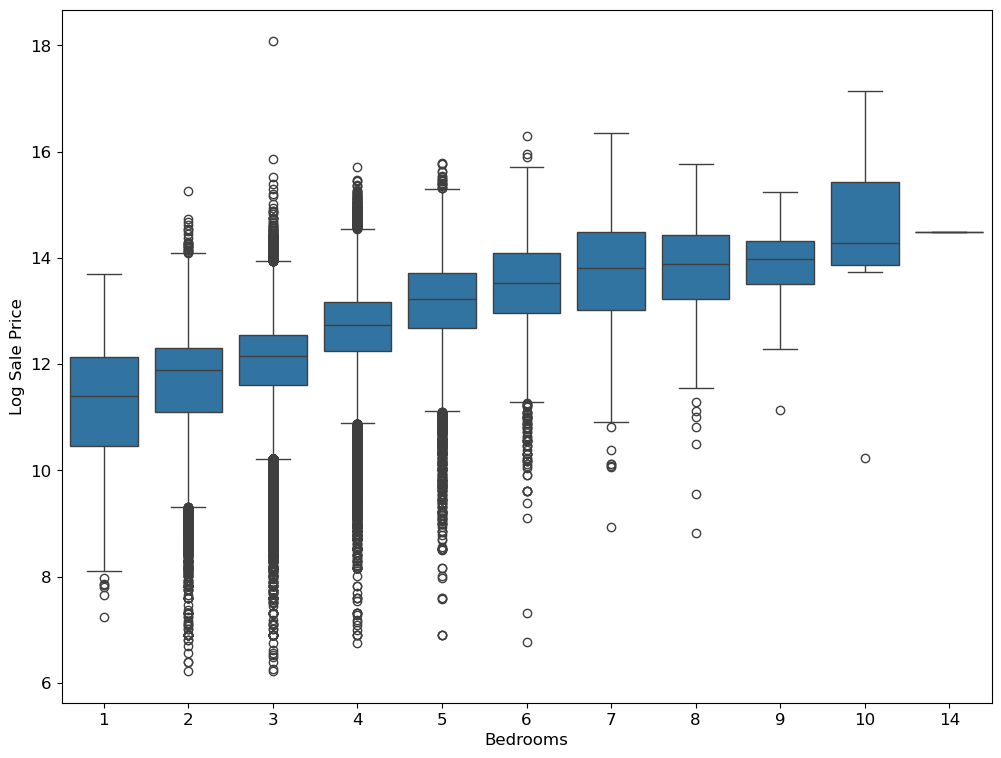

In [41]:
sns.boxplot(data = training_data, x = "Bedrooms", y = "Log Sale Price")

Much better! Now let's check how the other two rooms correlate with log sale price.

<Axes: xlabel='Bathrooms', ylabel='Log Sale Price'>

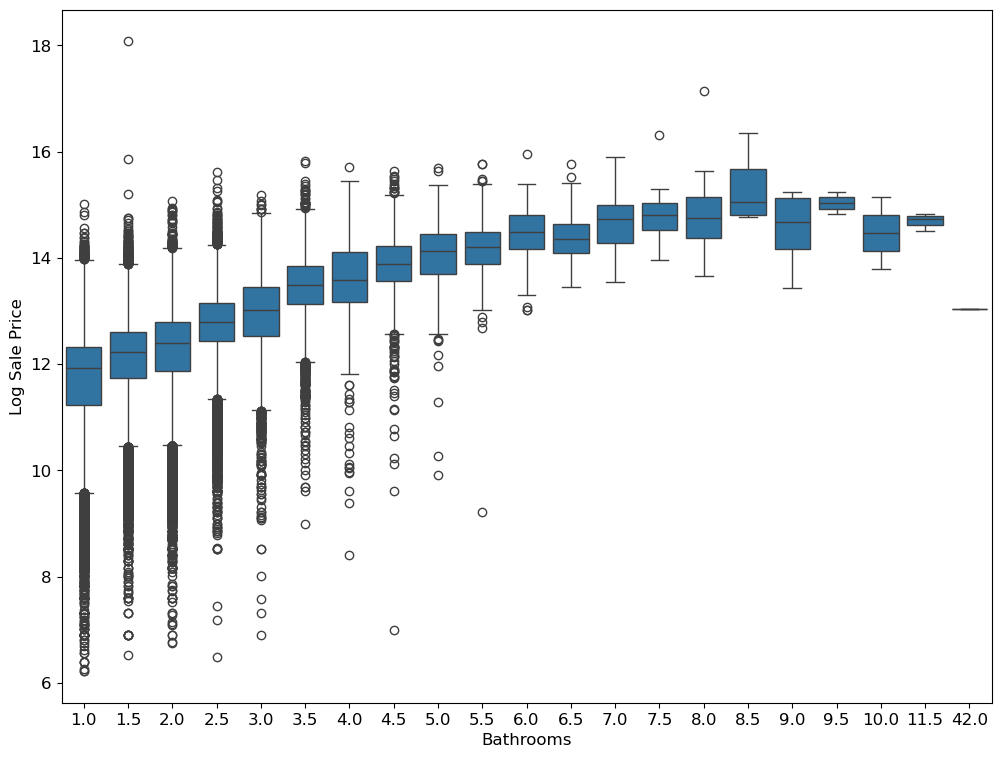

In [43]:
sns.boxplot(data = training_data, x = "Bathrooms", y = "Log Sale Price")

<Axes: xlabel='Bedrooms', ylabel='Log Sale Price'>

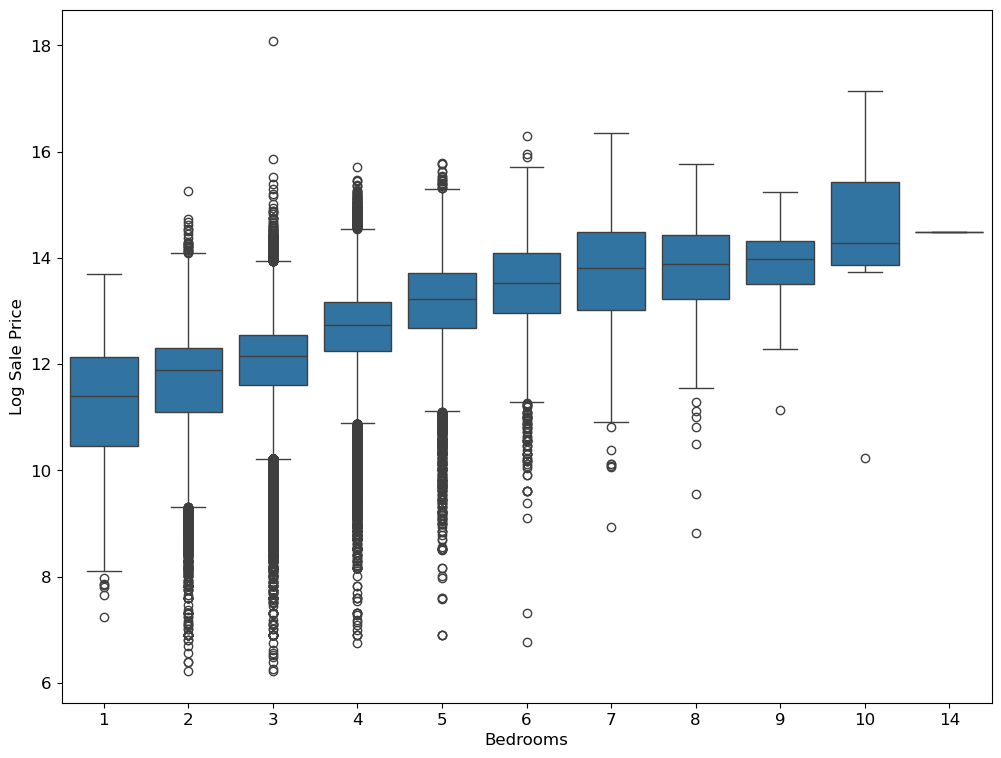

In [44]:
sns.boxplot(data = training_data, x = "Bedrooms", y = "Log Sale Price")

The box plots allow us to get a much nicer look of the data despite how many data points there may still be. It looks like these features have a nice correlation with log sale price! Now let's look at other variables once more.

In [191]:
num_neighborhoods = training_data['Neighborhood Code'].unique().size
num_neighborhoods

193

In [193]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows = 2)

    sns.boxplot(
        x = 'Neighborhood Code',
        y = 'Log Sale Price',
        data = neighborhoods,
        ax = axs[0],
    )

    sns.countplot(
        x = 'Neighborhood Code',
        data = neighborhoods,
        ax= axs[1]
    )

    axs[0].axhline(
        y = training_data['Log Sale Price'].median(),
        color = 'red',
        linestyle = 'dotted'
    )

    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha = 'center', va = 'bottom')
        
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation = 90)
    axs[0].xaxis.set_visible(False)

    plt.subplots_adjust(hspace = 0.01)

/var/folders/mx/zvd2kjjx4z704zflxmthfp380000gn/T/ipykernel_44511/112767469.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation = 90)


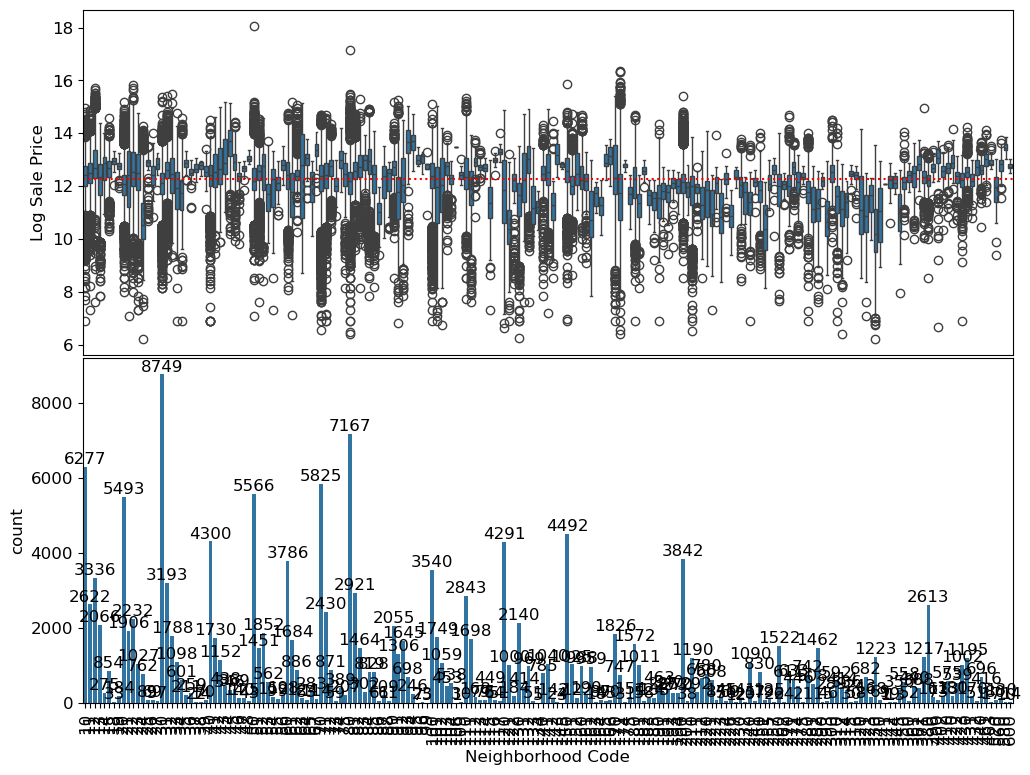

In [195]:
plot_categorical(training_data)

In [196]:
top_20_neighborhood_codes = training_data.groupby("Neighborhood Code")['Neighborhood Code'].value_counts(ascending = False).sort_values(ascending = False).index[:20]
in_top_20_neighborhoods = training_data[training_data["Neighborhood Code"].isin(top_20_neighborhood_codes)]

/var/folders/mx/zvd2kjjx4z704zflxmthfp380000gn/T/ipykernel_44511/112767469.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation = 90)


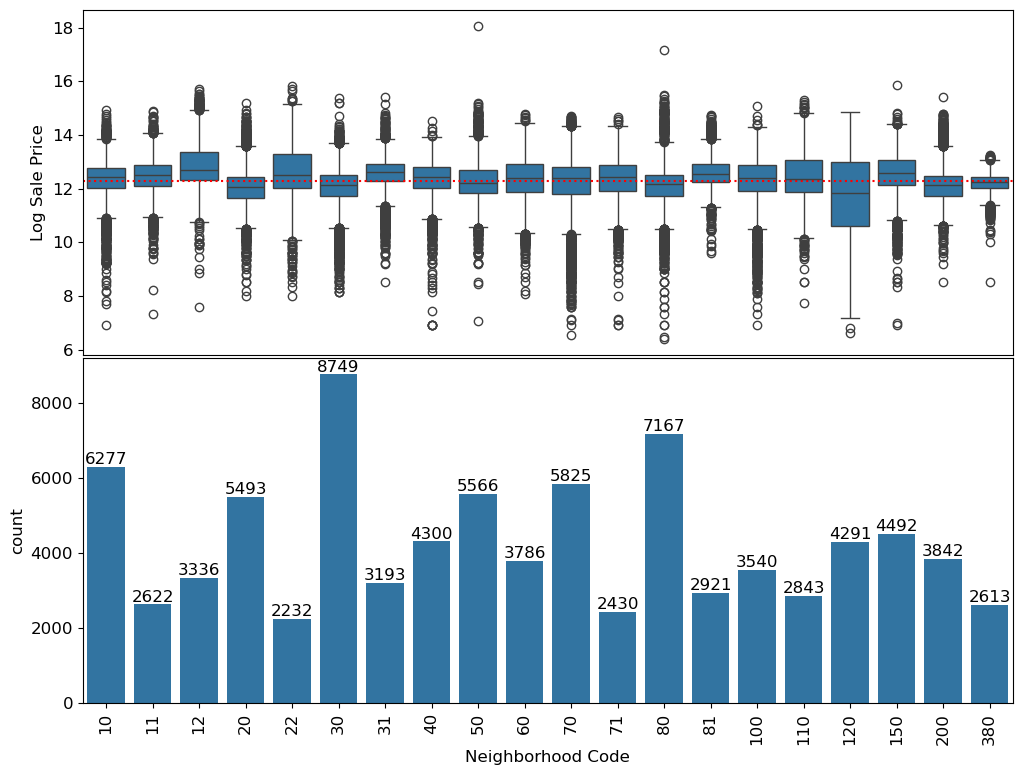

In [197]:
plot_categorical(neighborhoods = in_top_20_neighborhoods)

In [201]:
def find_expensive_neighborhoods(data, n=3, metric = "median"):
    neighborhoods = data.groupby("Neighborhood Code")["Log Sale Price"].agg(metric).sort_values(ascending = False).index[:n]
    return [int(code) for code in neighborhoods]
expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, "median")
expensive_neighborhoods

[44, 94, 93]

In [203]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, "median")
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In [205]:
def substitute_roof_material(data):
    copy = data.copy()
    copy["Roof Material"] = copy['Roof Material'].map({1:"Shingle/Asphalt", 2:"Tar & Gravel", 3:"Slate", 4: "Shake", 5: "Tile", 6: "Other"})
    return copy

training_data_mapped = substitute_roof_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bathrooms,Bedrooms,Rooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,1.0,3,6,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,1.0,3,7,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,1.5,3,5,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,1.0,2,5,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,1.5,4,6,0


In [207]:
from sklearn.preprocessing import OneHotEncoder
def ohe_roof_material(data):
    cat = ['Roof Material']
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[cat])

    cat_data = oh_enc.transform(data[cat]).toarray()
    cat_df = pd.DataFrame(data = cat_data, columns = oh_enc.get_feature_names_out(), index = data.index)
    return data.join(cat_df)

In [209]:
training_data_ohe = ohe_roof_material(training_data_mapped)
training_data_ohe.filter(regex = '^Roof Material_').head(10)                            

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar & Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


In [211]:
test_data = pd.read_csv("cook_county_test.csv", index_col = "Unnamed: 0")

In [212]:
def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices = shuffled_indices[:int(data_len * 0.8)]
    validation_indices = shuffled_indices[int(data_len * 0.8):]
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]

    return train, validation

In [215]:
def process_data_simple(data):
    data = remove_outliers(data, 'Sale Price', lower = 499)
    data = log_transform(data, 'Sale Price')
    data = add_bedrooms(data)
    X = data[['Bedrooms']]
    Y = data['Log Sale Price']
    return X, Y

full_data = pd.read_csv("cook_county_train.csv")

train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = process_data_simple(valid_m1)

display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,Bedrooms
58093,3
130549,3
201065,3
65498,3
132659,4


58093     12.691580
130549    12.042965
201065    12.933621
65498     12.637855
132659    13.005830
Name: Log Sale Price, dtype: float64

In [216]:
def process_data_pipe(data, pipeline_functions, prediction_col):
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns = [prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

In [217]:
full_data = pd.read_csv('cook_county_train.csv')
train_m1, valid_m1 = train_val_split(full_data)

def select_columns(data, *columns):
    return data.loc[:, columns]

m1_pipelines = [
    (remove_outliers, None, {'variable':'Sale Price', 'lower': 499}),
    (log_transform, None, {'col':'Sale Price'}),
    (add_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, Y_train_m1 = process_data_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = process_data_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

display(X_train_m1.head())
display(Y_train_m1.head())

,Bedrooms
151889,3
100667,2
29247,4
52588,4
90307,3


151889    10.585498
100667    12.072541
29247     12.273731
52588      9.975808
90307     12.905450
Name: Log Sale Price, dtype: float64

In [220]:
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':499
    }),
    (log_transform, None, {'col':'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]

X_train_m2, Y_train_m2 = process_data_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = process_data_pipe(valid_m2, m2_pipelines, 'Log Sale Price')

display(X_train_m2.head())
display(Y_train_m2.head())

,Bedrooms,Log Building Square Feet
116756,2,7.433667
203058,3,7.066467
105072,3,7.053586
115492,3,7.645398
163646,3,7.080868


116756    12.183316
203058    12.751300
105072    11.973510
115492    12.874287
163646    11.934920
Name: Log Sale Price, dtype: float64

In [221]:
linear_model_m1 = lm.LinearRegression(fit_intercept = True)
linear_model_m2 = lm.LinearRegression(fit_intercept = True)

In [222]:
linear_model_m1.fit(X_train_m1, Y_train_m1)
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

linear_model_m2.fit(X_train_m2, Y_train_m2)
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

In [223]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

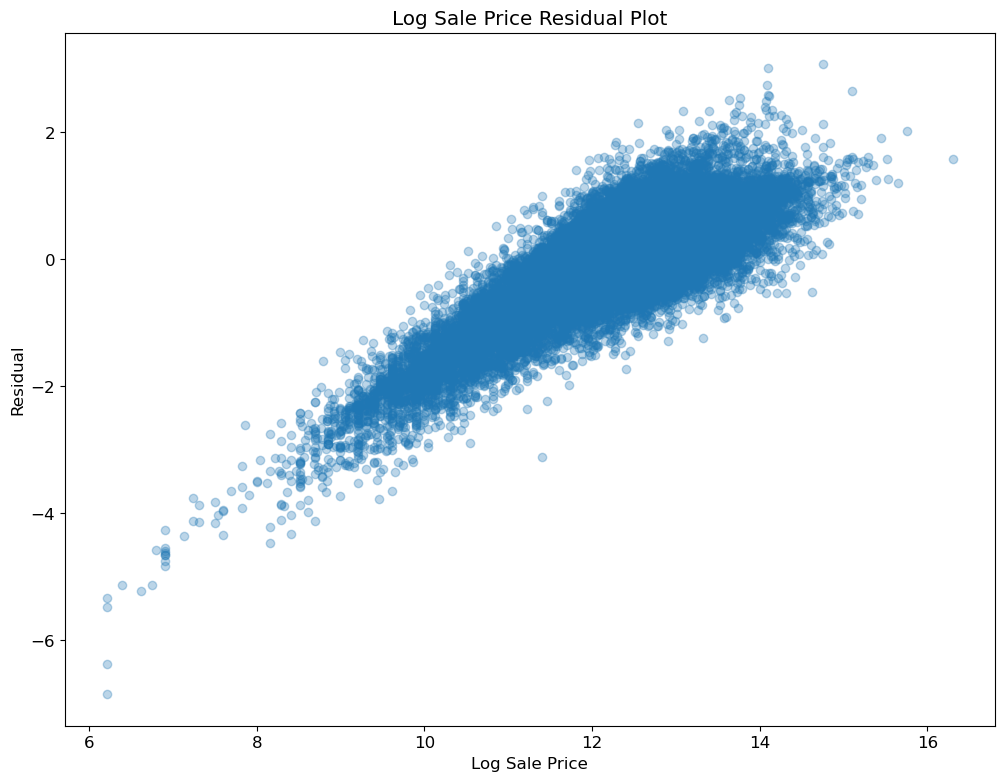

In [224]:
plt.scatter(Y_valid_m2, Y_valid_m2 - Y_predicted_m2, alpha = 0.3)
plt.xlabel("Log Sale Price")
plt.ylabel("Residual")
plt.title("Log Sale Price Residual Plot");

In [226]:
def process_data_pipe(data, pipeline_functions, prediction_col):
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns = [prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

In [231]:
train, validation = train_val_split(training_data)

In [234]:
from helper_functions import *

final_pipelines = [
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':500
    }),
    (remove_outliers, None, {
        'variable':'Estimate (Building)',
        'lower':2500
    }),
    (remove_outliers, None, {
        'variable':'Estimate (Land)',
        'lower':2500
    }),
    (log_transform, None, {'col':'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (log_transform, None, {'col': 'Estimate (Land)'}),
    (log_transform, None, {'col': 'Estimate (Building)'}),
    (add_bedrooms, None, None),
    (add_bathrooms, None, None),
    (add_total_rooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet', 'Bedrooms', 'Rooms', 'Bathrooms', 
                      'Log Land Square Feet', 'Log Lot Size', 'Log Estimate (Building)', 'Log Estimate (Land)', 'Age'], None)
]
def process_data_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        copy = data.copy()
        fill_missing = ['Building Square Feet', 'Age', 'Lot Size', 'Estimate (Building)', 'Estimate (Land)']
        for col in fill_missing:
            copy[col] = copy[col].fillna(np.median(copy[col]))
        X, Y = process_data_pipe(copy, final_pipelines, 'Log Sale Price')
        return X, Y
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        copy = data.copy()
        fill_missing = ['Building Square Feet', 'Age', 'Lot Size', 'Estimate (Building)', 'Estimate (Land)']
        for col in fill_missing:
            copy[col] = copy[col].fillna(np.median(copy[col]))
        X, Y = process_data_pipe(copy, final_pipelines, 'Log Sale Price')
        return X
        

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 293651.56379540864


In [236]:
train, validation = train_val_split(training_data)
remove_outliers_validation = [
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':500
    }),
    (remove_outliers, None, {
        'variable':'Estimate (Building)',
        'lower':2500
    }),
    (remove_outliers, None, {
        'variable':'Estimate (Land)',
        'lower':2500
    })
]

validation, price =process_data_pipe(validation, remove_outliers_validation, 'Log Sale Price')
validation['Log Sale Price'] = price

In [237]:
import sklearn
X,Y = process_data_final(train, is_test_set = False)
a = process_data_final(validation, is_test_set = True)
my_model = sklearn.linear_model.LinearRegression().fit(X, Y)
predicted = my_model.predict(a)
rmse(np.exp(predicted), validation['Sale Price'])

238355.50121383465

This is not bad for a linear model, but we know that this region has been historically red-lined. Is it really right for us to use biased data to make our prediction? Let's try making a model without including the previous year's estimations. 

In [ ]:
from helper_functions import *

final_pipelines = [
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':500
    }),
    (log_transform, None, {'col':'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (add_bedrooms, None, None),
    (add_bathrooms, None, None),
    (add_total_rooms, None, None),
    (substitute_roof_material, None, None),
    (ohe_roof_material, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet', 'Bedrooms', 'Rooms', 'Bathrooms', 
                      'Log Land Square Feet', 'Log Lot Size', 'Age', 'Roof Material_Other',
                      'Roof Material_Shake', 'Roof Material_Shingle/Asphalt',
                      'Roof Material_Slate', 'Roof Material_Tar & Gravel', 'Roof Material_Tile'], None)
]
def process_data_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        copy = data.copy()
        fill_missing = ['Building Square Feet', 'Age', 'Lot Size']
        for col in fill_missing:
            copy[col] = copy[col].fillna(np.median(copy[col]))
        X, Y = process_data_pipe(copy, final_pipelines, 'Log Sale Price')
        return X, Y
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        copy = data.copy()
        fill_missing = ['Building Square Feet', 'Age', 'Lot Size']
        for col in fill_missing:
            copy[col] = copy[col].fillna(np.median(copy[col]))
        X, Y = process_data_pipe(copy, final_pipelines, 'Log Sale Price')
        return X
        

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

In [255]:
train, validation = train_val_split(training_data)
remove_outliers_validation = [
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':500
    }),
    (substitute_roof_material, None, None),
    (ohe_roof_material, None, None)
]

validation, price =process_data_pipe(validation, remove_outliers_validation, 'Log Sale Price')
validation['Log Sale Price'] = price

In [257]:
import sklearn
X,Y = process_data_final(train, is_test_set = False)
a = process_data_final(validation, is_test_set = True)
my_model = sklearn.linear_model.LinearRegression().fit(X, Y)
predicted = my_model.predict(a)
rmse(np.exp(predicted), validation['Sale Price'])

237685.47665840294

Now let's try some different models!

In [261]:
full_data = pd.read_csv('cook_county_train.csv')
full_data.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 'Estimate (Land)', 
                'Estimate (Building)'
               ], axis=1, inplace=True)
train, valid = train_val_split(full_data)

train.columns = [
    col.replace(" ", "_")          # remove spaces
       .replace("(", "")           # remove parentheses
       .replace(")", "")
       .replace("-", "_")          # replace dashes with underscores
       .replace("/", "_")          # replace slashes with underscores
    for col in train.columns
]
valid.columns = [
    col.replace(" ", "_")          # remove spaces
       .replace("(", "")           # remove parentheses
       .replace(")", "")
       .replace("-", "_")          # replace dashes with underscores
       .replace("/", "_")          # replace slashes with underscores
    for col in train.columns
]
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label='Sale_Price', task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid, label = 'Sale_Price', task = tfdf.keras.Task.REGRESSION)

In [262]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [264]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=['RootMeanSquaredError'])

Use /var/folders/mx/zvd2kjjx4z704zflxmthfp380000gn/T/tmpxuhypid8 as temporary training directory


In [267]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:11.709914. Found 163833 examples.
Training model...


I0000 00:00:1742679130.786476 11033735 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742679130.787989 11033735 kernel.cc:783] Collect training examples
I0000 00:00:1742679130.788004 11033735 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742679130.791179 11033735 kernel.cc:401] Number of batches: 164
I0000 00:00:1742679130.791190 11033735 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742679130.899667 11033735 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:65.9888 min:1 max:172 sd:29.0283
	1: "Age_Decade" NUMERICAL mean:6.59888 min:0.1 max:17.2 sd:2.9

Model trained in 0:01:39.848349
Compiling model...
Model compiled.


In [268]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx = 0, max_depth = 3)

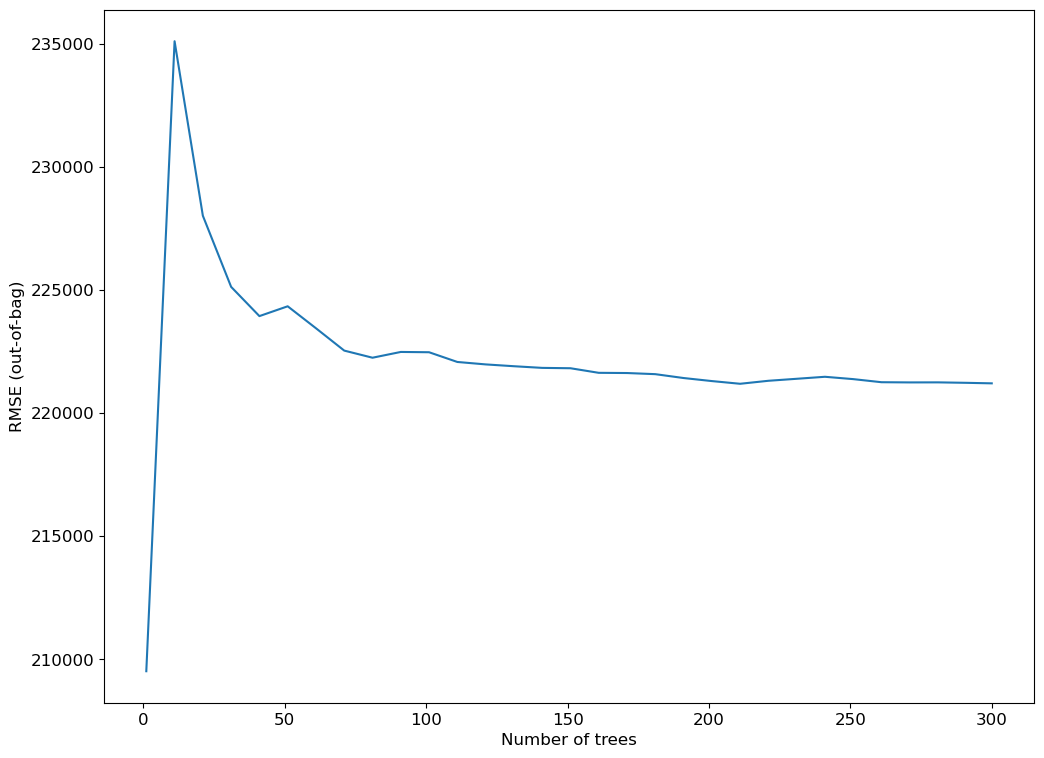

In [269]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [270]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=163833, accuracy=None, loss=None, rmse=221202.43546576702, ndcg=None, aucs=None, auuc=None, qini=None)

In [277]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

41/41 [==============================] - 7s 150ms/step - loss: 0.0000e+00 - root_mean_squared_error: 112820.4531
loss: 0.0000
root_mean_squared_error: 112820.4531


In [279]:
full_data = pd.read_csv('cook_county_train.csv')
full_data['Sale Price']

0              1
1         285000
2          22000
3         225000
4          22600
           ...  
204787     37100
204788    225000
204789    135000
204790    392000
204791    125000
Name: Sale Price, Length: 204792, dtype: int64

In [280]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 NUM_AS_ROOT


In [283]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("Building_Square_Feet" (1; #7), 96.0),
 ("Property_Class" (1; #37), 77.0),
 ("Pure_Market_Filter" (1; #38), 44.0),
 ("Fireplaces" (1; #13), 39.0),
 ("Age" (1; #0), 14.0),
 ("Age_Decade" (1; #1), 13.0),
 ("Latitude" (1; #25), 13.0),
 ("Cathedral_Ceiling" (1; #8), 1.0),
 ("Census_Tract" (1; #9), 1.0),
 ("Central_Air" (1; #10), 1.0),
 ("Roof_Material" (1; #41), 1.0)]

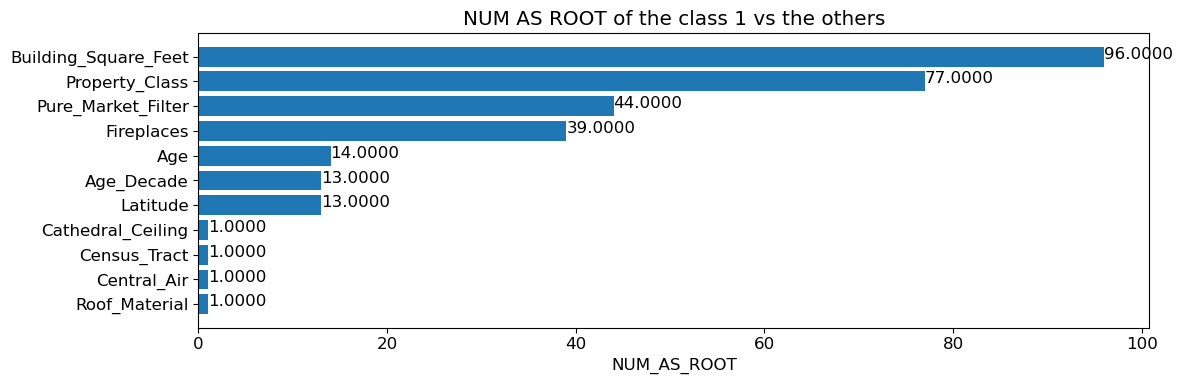

In [285]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [297]:
full_data = pd.read_csv('cook_county_train.csv')
full_data = log_transform(full_data, 'Sale Price')
full_data.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 
                'Estimate (Land)', 'Estimate (Building)'
               ], axis=1, inplace=True)
numeric_cols = full_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_ds = full_data[numeric_cols]

<Axes: >

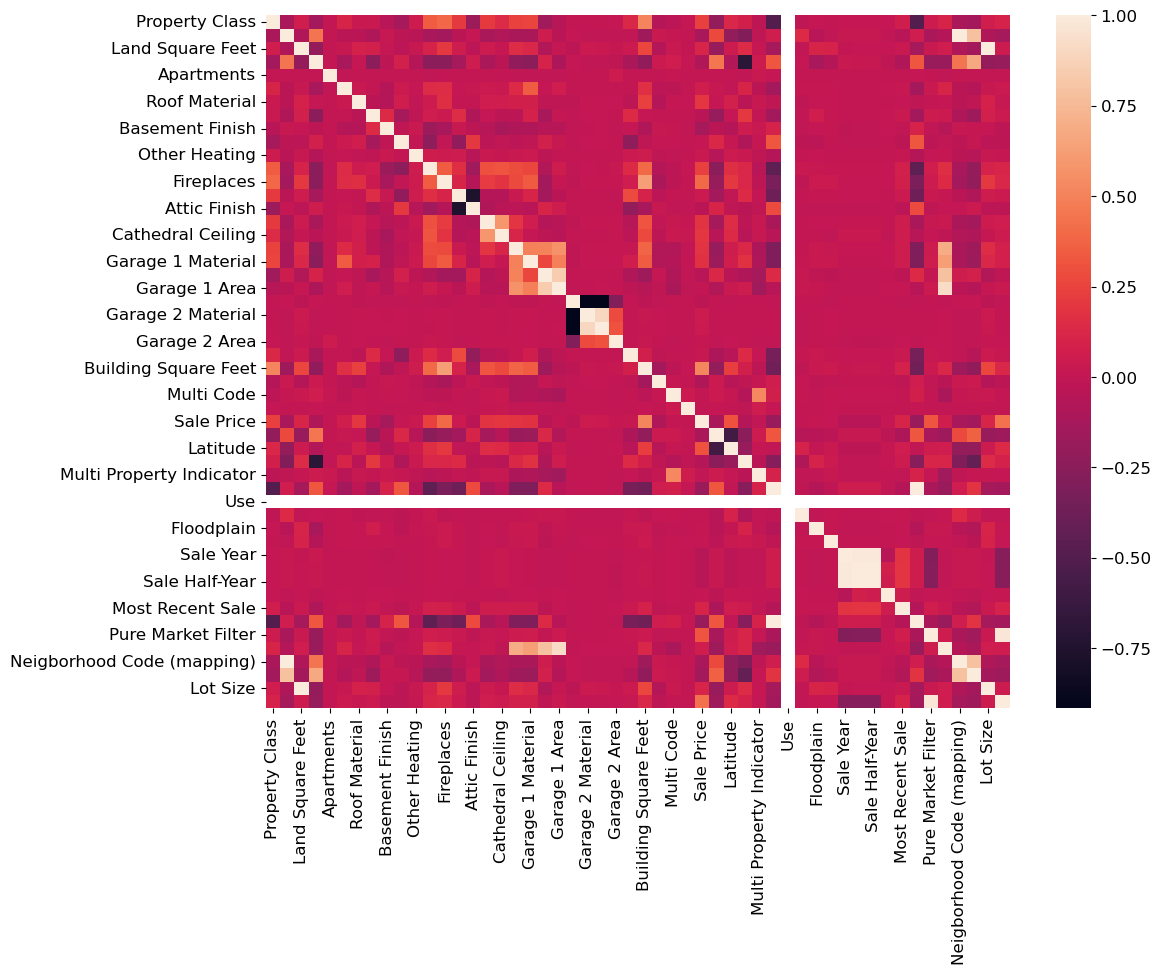

In [299]:
correlation_matrix = numeric_ds.corr()
sns.heatmap(correlation_matrix)

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential


def rmse_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

X = numeric_ds.drop('Sale Price', axis = 1)
y = numeric_ds['Sale Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
input_dim = X_train.shape[1]

model = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1)
])

model.compile(optimizer = 'adam', loss = rmse_loss, metrics = [tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# 7. Evaluating the Model
loss, rmse = model.evaluate(X_test, y_test)
print("Test RMSE:", rmse)

Epoch 1/100
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 3s 617us/step - loss: 332166.2188 - root_mean_squared_error: 369836.9375 - val_loss: 203258.3594 - val_root_mean_squared_error: 239883.2344
Epoch 2/100
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - loss: 181513.0156 - root_mean_squared_error: 255209.0781 - val_loss: 161097.6406 - val_root_mean_squared_error: 202011.8125
Epoch 3/100
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step - loss: 151714.1562 - root_mean_squared_error: 204173.3438 - val_loss: 152384.6719 - val_root_mean_squared_error: 193240.2031
Epoch 4/100
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 2s 571us/step - loss: 148977.4219 - root_mean_squared_error: 222410.6406 - val_loss: 146938.2188 - val_root_mean_squared_error: 188197.1719
Epoch 5/100
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 2s 603us/step - loss: 141981.9219 - root_mean_squared_error: 204004.9844 - val_loss: 142089.4688 - val_root_mean_squared_error: 183250.6406
Epoch 6/100
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - loss: 139663.5781 - root_m

In [607]:
best_model = model

In [609]:
model

<Sequential name=sequential_2, built=True>